# Flex Net: 2A Configurable Neural Network for Sound Parsing

### Avant Garde Composer

Code to generate batches of random marimba compositions (with piano roll and corresponding audio)

In [ ]:
import tensorflow as tf
from sonic2 import *

class Generate_Batch():
    def __init__(self, batch_size, length_in_beats, sample_rate, bpm):
        self.song = Song(SampleBank(restricted_instruments=['Marimba_cord_ff']),
                         length_in_beats, bpm, sample_rate)
        self.batch_size = batch_size
        self.num_inst_samples = self.song.num_inst_samples
        self.length_in_beats = length_in_beats
        self.bpm = bpm
        self.sr = sample_rate
        self.N = self.sr * self.length_in_beats * 60 // self.bpm
        self.samples_per_beat = (self.sr * 60) // self.bpm
        self.batch_audio = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.samples_per_beat*5], dtype=tf.float32))
        self.batch_piano_roll = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.num_inst_samples], dtype=tf.float32))
    
    #@tf.function
    def __chop__(self, song_output, song_notes_float):
        audio = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.samples_per_beat*5,))
        piano_roll = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.num_inst_samples,))
        for j in tf.range(2, self.song.length_in_beats - 2):
            audio = audio.write(j-2, song_output[(j-2)*self.samples_per_beat:(j+3)*self.samples_per_beat])
            piano_roll = piano_roll.write(j-2, tf.reshape(song_notes_float, [self.song.length_in_beats, self.song.num_inst_samples])[j])
        return audio.stack(), piano_roll.stack()
    
    @tf.function
    def __call2__(self):
        for i in range(self.batch_size):
            output, notes_float = self.song.create()
            audio, piano_roll = self.__chop__(output, notes_float)
            self.batch_audio[i].assign(audio)
            self.batch_piano_roll[i].assign(piano_roll)
        return self.batch_audio, self.batch_piano_roll

    #@tf.function
    def __call__(self):
        for i in range(self.batch_size):
            self.song.zero()
            for j in range(np.random.choice([3,4,5,6,7,8,9,10,11,12])):
                self.song.generate()
            audio, piano_roll = self.__chop__(self.song.output, self.song.notes_float)
            self.batch_audio[i].assign(audio)
            self.batch_piano_roll[i].assign(piano_roll)
        return self.batch_audio, self.batch_piano_roll    

In [ ]:
batch_size = 10
batches_per_epoch = 1

generate_batch = Generate_Batch(batch_size, 4*10, 44100, 60*10)

In [ ]:
a, p = generate_batch()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(p[0].numpy(), aspect=(1), cmap='inferno')

In [ ]:
# Example of a random composition

from IPython.display import Audio

generate_batch.song.generate()
example_composition = generate_batch.song.output.numpy()

Audio(example_composition, rate=44100, autoplay=True)

## Neural Network Classes

In [122]:
import tensorflow as tf
from keras.layers import Layer

class STFT(Layer):
    def __init__(self, frame_length=1024, frame_step=256, fft_length=1024):
        super(STFT, self).__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length

    def build(self, input_shape):  # Create the state of the layer (weights)
        pass

    def call(self, inputs):  # Defines the computation from inputs to outputs
        stfts = tf.signal.stft(inputs, frame_length=self.frame_length, frame_step=self.frame_step,
                       fft_length=self.fft_length)
        spectrograms = tf.abs(stfts)
        return spectrograms

In [186]:
from keras import Model, Input
from keras.layers import Dense, Activation, Dropout, LSTM, Lambda, Reshape
from keras.optimizers import Adam

hidden_size = 128

def ConvLSTMModel(hidden_size, num_classes=61, frame_length=1024, frame_step=256, num_samples=176400, sample_rate=44100):
    
    # Compute fft_length (smallest power of 2 enclosing frame_length)
    for i in range(50):
        if (2 ** i) < frame_length <= (2 ** (i+1)):
            fft_length = 2 ** (i+1)
            break
    # Compute number of fft bins
    fft_unique_bins = fft_length // 2 + 1
    # Compute number of frames
    num_frames = ((num_samples - frame_length) // frame_step) + 1
    
    LSTM_cell = LSTM(hidden_size, return_state = True)
    Dense_cell = Dense(num_classes, activation='sigmoid')
    
    PCM = Input(shape=(num_samples,), name='pcm_input')    
    hidden_state_0 = Input(shape=(hidden_size,), name='hidden_state_0')
    cell_state_0 = Input(shape=(hidden_size,), name='cell_state_0')
    
    spec = STFT()(PCM)
    hidden_state = hidden_state_0
    cell_state = cell_state_0
    
    outputs = []
    for t in range(num_frames):
        spec_slice = Lambda(lambda x: x[:, t:t+1, :], output_shape=(1, 513))(spec)
        hidden_state, _, cell_state = LSTM_cell(spec_slice, initial_state=[hidden_state, cell_state])
        output = Dense_cell(hidden_state)
        outputs.append(output)
        
    model = Model(inputs=[PCM, hidden_state_0, cell_state_0], outputs=outputs)
    
    return model

model = ConvLSTMModel(hidden_size)

In [ ]:
model.summary()

optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pcm_input (InputLayer)          (None, 176400)       0                                            
__________________________________________________________________________________________________
stft_39 (STFT)                  (None, 176400)       0           pcm_input[0][0]                  
__________________________________________________________________________________________________
lambda_703 (Lambda)             (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
hidden_state_0 (InputLayer)     (None, 128)          0                                            
___________________________________________________________________________________________

                                                                 lstm_32[425][2]                  
                                                                 lambda_1130[0][0]                
                                                                 lstm_32[426][0]                  
                                                                 lstm_32[426][2]                  
                                                                 lambda_1131[0][0]                
                                                                 lstm_32[427][0]                  
                                                                 lstm_32[427][2]                  
                                                                 lambda_1132[0][0]                
                                                                 lstm_32[428][0]                  
                                                                 lstm_32[428][2]                  
          

lambda_815 (Lambda)             (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_816 (Lambda)             (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_817 (Lambda)             (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_818 (Lambda)             (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_819 (Lambda)             (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_820

lambda_1157 (Lambda)            (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_1158 (Lambda)            (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_1159 (Lambda)            (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_1160 (Lambda)            (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_1161 (Lambda)            (None, 1, 513)       0           stft_39[0][0]                    
__________________________________________________________________________________________________
lambda_116

In [188]:
test = np.reshape(output.numpy(), [1, -1])
print(test.shape)

hidden_state_0 = np.zeros((1,128))
cell_state_0 = np.zeros((1,128))

(1, 176400)


In [191]:
outputs = model.predict([test, hidden_state_0, cell_state_0])

In [192]:
outputs

[array([[0.5034341 , 0.5197813 , 0.496949  , 0.5178659 , 0.49347687,
         0.50188535, 0.49569902, 0.5071554 , 0.5130302 , 0.4922446 ,
         0.4948677 , 0.48916775, 0.50253975, 0.5050864 , 0.49113408,
         0.5010874 , 0.49831653, 0.50223094, 0.5081908 , 0.5005923 ,
         0.50244516, 0.49703252, 0.50095457, 0.49326044, 0.48468283,
         0.51489055, 0.50310713, 0.49987146, 0.49753496, 0.4883472 ,
         0.5072908 , 0.49734777, 0.50062823, 0.5093251 , 0.48934048,
         0.5137198 , 0.5024787 , 0.49749312, 0.50046027, 0.50155866,
         0.49562383, 0.5226185 , 0.505663  , 0.4956802 , 0.5105717 ,
         0.49966994, 0.49825877, 0.49995512, 0.5065782 , 0.49708977,
         0.506804  , 0.5058982 , 0.5065909 , 0.5054974 , 0.4940708 ,
         0.48859367, 0.512577  , 0.5049778 , 0.5146176 , 0.49435988,
         0.5030835 ]], dtype=float32),
 array([[0.5062104 , 0.5344321 , 0.4946056 , 0.52900046, 0.48851475,
         0.5039702 , 0.4939214 , 0.51376307, 0.52148926, 0.48676

In [164]:
print(a.shape, b.shape, c.shape)

(1, 128) (1, 128) (1, 128)


In [ ]:
from neural2 import *

sample_rate = 44100                 # 44.1khz sample rate
frame_length = sample_rate // 10    # frame size of 0.1 seconds
num_frames = 5                      # five frames read at a time
input_features = int(frame_length * num_frames)
    
dl = DisperseLayer(input_features, frame_length, 1.0)
rl = RFFTLayer(dl.chunk_size)

In [33]:
from sonic2 import *

length_in_beats = 40
bpm = 600
sample_rate = 44100

song = Song(SampleBank(restricted_instruments=['Marimba_cord_ff']),
            length_in_beats, bpm, sample_rate)

Marimba_cord_ff  --- notes  36  through  96


In [34]:
output, notes_float = song.create()

In [36]:
stft = STFT()

In [37]:
x = tf.identity(output)

In [38]:
spec = stft(x)

In [39]:
spec

<tf.Tensor 'stft_2/Abs:0' shape=(686, 513) dtype=float32>

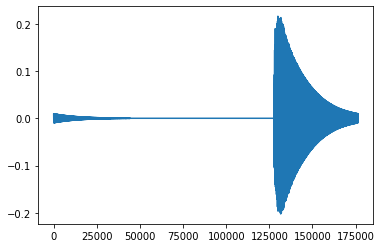

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(len(x.numpy())), x.numpy())

In [41]:
from IPython.display import Audio

Audio(x.numpy(), rate=44100, autoplay=True)

In [61]:
spec = tf.abs(tf.signal.stft(x, frame_length=1024, frame_step=256,
                       fft_length=1024))

In [62]:
spec.shape

TensorShape([686, 513])

In [63]:
np.max(spec, axis=0)

array([1.09546351e+00, 7.55832613e-01, 8.39584947e-01, 1.57459545e+00,
       1.21932631e+01, 4.97434273e+01, 4.47154083e+01, 7.59757137e+00,
       2.21139669e+00, 2.49897480e+00, 2.25450516e+00, 2.44972682e+00,
       2.71094370e+00, 3.12094283e+00, 3.40513039e+00, 3.97055936e+00,
       5.54367971e+00, 4.20496750e+00, 1.66566467e+00, 7.60774910e-01,
       1.63072491e+00, 6.88032293e+00, 1.00154705e+01, 5.03085852e+00,
       1.43413746e+00, 1.37474132e+00, 1.60467565e+00, 1.96961319e+00,
       1.40611136e+00, 1.02192461e+00, 1.11397207e+00, 1.27444971e+00,
       1.44468343e+00, 1.06370020e+00, 6.32043958e-01, 6.28847599e-01,
       7.13880777e-01, 5.11388123e-01, 3.13819557e-01, 1.97495803e-01,
       1.61437288e-01, 2.70275533e-01, 4.43124712e-01, 3.31337839e-01,
       2.01336607e-01, 2.61150092e-01, 4.01576638e-01, 7.11953402e-01,
       7.56517053e-01, 5.70363939e-01, 5.48123837e-01, 6.26597762e-01,
       8.03004861e-01, 1.58197403e+00, 3.69466090e+00, 5.09654188e+00,
      

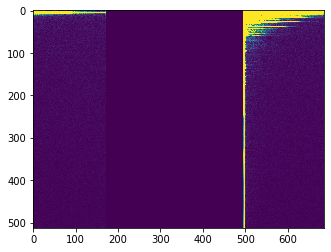

In [65]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

plt.imshow(spec.numpy().T, vmin=0.0, vmax=0.01)

In [ ]:
x = dl(a)

In [ ]:
x.shape

In [ ]:
a.shape

In [ ]:
from neural2 import *

class Network(tf.Module):
    def __init__(self, name=None):
        super(Network, self).__init__(name=name)
        self.layers = []
        
                
        sample_rate = 44100                 # 44.1khz sample rate
        frame_length = sample_rate // 10    # frame size of 0.1 seconds
        num_frames = 5                      # five frames read at a time
        input_features = int(frame_length * num_frames)
    
        self.layers.append(DisperseLayer(input_features, frame_length, 1.0))
        num_chunks = num_frames
        
        self.layers.append(RFFTLayer(self.layers[-1].chunk_size))
        
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features))
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features // 64))
    
        
        self.layers.append(JoinLayer(self.layers[-1].output_features, num_chunks))
        
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features // 4))
        self.layers.append(SigmoidNormLayer(self.layers[-1].output_features, 61))
        

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        for i, layer in enumerate(self.layers):
            if not os.path.exists(os.path.join(path, f'layer_{i}')):
                os.makedirs(os.path.join(path, f'layer_{i}'))
            layer.save(os.path.join(path, f'layer_{i}'))
            
    def load(self, path):
        for i, layer in enumerate(self.layers):
            layer.load(os.path.join(path, f'layer_{i}'))
        
    def apply(self, data, layers):
        if len(layers) == 1:
            return layers[0](data)
        else:
            return self.apply(layers[0](data), layers[1:])

    #@tf.function
    def __call__(self, data):
        x = data
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
        #return self.apply(data, self.layers)
        
    def reset(self):
        for layer in self.layers:
            layer.reset()

network = Network()

In [ ]:
def clean_output(arr):
    N = arr.shape[0]
    M = arr.shape[1]
    output = np.zeros([N, M])
    for i in range(N):
        for j in range(M):
            output[i][j] = int(max(0, min(127, round(128 * arr[i][j]))))
    return output

In [ ]:
network.reset()

In [ ]:
from IPython.display import display, clear_output, Audio
import seaborn as sns
import sys, signal
import matplotlib.pyplot as plt
import plotting

keep_going = True
def signal_handler(signal, frame):
    global keep_going
    keep_going = False
signal.signal(signal.SIGINT, signal_handler)

#@tf.function
def loss(trainable_variables, notes_actual, notes_predicted):
    note_cost1 = tf.reduce_mean((notes_actual - notes_predicted)**2)
    #note_cost2 = tf.reduce_mean(-notes_actual * tf.math.log(10**(-6) + notes_predicted) - (1 - notes_actual) * tf.math.log((1 + 10**(-6)) -  notes_predicted))
    #regularization_cost = 0.0
    #for i in range(len(trainable_variables)):
    #    regularization_cost +=  (1/100) * tf.reduce_sum(tf.math.maximum(trainable_variables[i], 0.0))
    cost = note_cost1
    tf.print('Cost:', cost, 'Note Cost:', note_cost1) #, 'Regularization Cost:', regularization_cost)
    return cost
    

@tf.function
def grad(network, input_pcms, notes_actual):
    with tf.GradientTape() as tape:
        tape.watch(network.trainable_variables)
        notes_predicted = network(input_pcms)
        loss_value = loss(network.trainable_variables, notes_actual, notes_predicted)
    return loss_value, notes_predicted, tf.clip_by_global_norm(tape.gradient(loss_value, network.trainable_variables), 1000000.0)

#@tf.function
def apply_grads(trainable_vars, grads, learning_rate):
    for i in range(len(grads)):
        trainable_vars[i].assign_sub(learning_rate * grads[i])

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) #, momentum=0.01) #, momentum=0.1, nesterov=True)
#optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)


num_inst_samples = 61
length_in_seconds = 4
quantization = 10
length_in_beats = length_in_seconds * quantization


learning_rate = 0.5
beta = 0.9
                                                          
grads = tuple(tf.Variable(tf.zeros_like(var, dtype=tf.float32)) for var in network.trainable_variables)
v = tuple(tf.Variable(tf.zeros_like(var, dtype=tf.float32)) for var in network.trainable_variables) 

i = -1
while keep_going:
    i += 1
    if i % 1000 == 0:                           
        input_pcms, notes_actual = generate_batch()

    loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
    print('Global Norm:', global_norm.numpy())
    for j in range(len(grads)):
        grads[j].assign_add(tf.where(tf.math.is_nan(new_grads[j]), tf.zeros_like(new_grads[j]), new_grads[j]) / batches_per_epoch)

    if i % 100 == 99:
        clear_output()
        
    if i % 10 == 0:
        pass
        fig = plotting.error(notes_predicted, notes_actual)
        display(fig)
        plt.close(fig)
        del fig

    
    if (i % batches_per_epoch) == (batches_per_epoch - 1):
        for j in range(len(grads)):
            v[j].assign(beta * v[j] + (1.0 - beta) * grads[j])
        apply_grads(network.trainable_variables, grads, learning_rate)
        #optimizer.apply_gradients(zip(grads, network.trainable_variables))
    
        for j in range(len(grads)):
            grads[j].assign(tf.zeros_like(network.trainable_variables[j], dtype=tf.float32))

        print(f'Epoch {i // batches_per_epoch} completed!')
        
    if i % 1000 == 999:
        network.save('checkpoint4')
        print('Network Parameters Saved!')

    print('Step', i, 'complete.')


### Saving and Loading

In [ ]:
network.save('checkpoint4')

In [ ]:
network.load('checkpoint3')

### To run a single test example

In [ ]:
import plotting

input_pcms, notes_actual = generate_batch()

loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
        
plt = plotting.error(notes_predicted, notes_actual)

del plt

In [ ]:
import gc

gc.collect()